# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [60]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [61]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

# Import Data

In [62]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [73]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    sfo_yearly_housing = sfo_data['housing_units'].groupby(['year']).mean()
    sfo_yearly = sfo_data.groupby(['year']).mean()
    min = sfo_yearly_housing.min()
    max = sfo_yearly_housing.max()
    std = sfo_yearly_housing.std()
    housing_units_per_year = sfo_yearly_housing.plot.bar(ylim = (min - std, max + std))
    housing_units_per_year.set_title('Housing units in San-Francisco 2010-2016', fontsize=14, fontweight='bold')
    housing_units_per_year.set_ylabel('Housing Units')
    return housing_units_per_year


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    sfo_yearly = sfo_data.groupby(['year']).mean()
    avg_rent = sfo_yearly['gross_rent']
    avg_sqfoot = sfo_yearly['sale_price_sqr_foot']
    avg_rent_by_sqfoot = sfo_yearly[['sale_price_sqr_foot', 'gross_rent']]
    gross_rent_plot = avg_rent.plot.line()
    average_gross_rent = gross_rent_plot.set_title('Average Gross Rent in San-Francisco', fontsize=14, fontweight='bold')
#     average_gross_rent.set_ylabel(ylabel = 'Rent', fontsize=12, fontweight='bold', inplace=True)
#     average_gross_rent.set_xlabel(xlabel = 'Rent', fontsize=12, fontweight='bold', inplace=True)
    return average_gross_rent


def average_sales_price():
    """Average Sales Price Per Year."""
    sfo_yearly = sfo_data.groupby(['year']).mean()
    avg_sqfoot = sfo_yearly['sale_price_sqr_foot']
    average_sales_price = avg_sqfoot.plot.line(title='Average Sales Price per Year')
    return average_sales_price


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    sfo_neighbohood_yearly = sfo_data.groupby(['year', 'neighborhood']).mean()
    sfo_neighbohood_yearly.reset_index(inplace=True)
    average_price_by_neighborhood = sfo_neighbohood_yearly.hvplot.line( x='year', y='sale_price_sqr_foot', groupby='neighborhood')
    return average_price_by_neighborhood


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    expensive_neighborhoods = sfo_data.groupby('neighborhood').mean()
    expensive_neighborhoods.sort_values(by = 'sale_price_sqr_foot', ascending=False, inplace=True)
    expensive_neighborhoods.reset_index(inplace=True)
    expensive_neighborhoods = expensive_neighborhoods.head(10)
    top_most_expensive_neighborhoods = expensive_neighborhoods.hvplot.line(x='neighborhood', y='sale_price_sqr_foot',rot=90)
    return top_most_expensive_neighborhoods

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    expensive_neighborhoods = sfo_data.groupby('neighborhood').mean()
    expensive_neighborhoods.sort_values(by = 'sale_price_sqr_foot', ascending=False, inplace=True)
    expensive_neighborhoods.reset_index(inplace=True)
    expensive_neighborhoods = expensive_neighborhoods.head(10)
    top_most_expensive_neighborhoods = expensive_neighborhoods.hvplot.line(x='neighborhood', y='sale_price_sqr_foot',rot=90)
    parallel_coordinates = px.parallel_coordinates(expensive_neighborhoods, color="sale_price_sqr_foot", color_continuous_scale = px.colors.sequential.Inferno)
    return parallel_coordinates

def parallel_categories():
    """Parallel Categories Plot."""
    expensive_neighborhoods = sfo_data.groupby('neighborhood').mean()
    expensive_neighborhoods.sort_values(by = 'sale_price_sqr_foot', ascending=False, inplace=True)
    expensive_neighborhoods.reset_index(inplace=True)
    expensive_neighborhoods = expensive_neighborhoods.head(10)
    top_most_expensive_neighborhoods = expensive_neighborhoods.hvplot.line(x='neighborhood', y='sale_price_sqr_foot',rot=90)
    parallel_categories = px.parallel_categories(expensive_neighborhoods.round(3), dimensions=['neighborhood', 'sale_price_sqr_foot', 'housing_units', 'gross_rent'], color="sale_price_sqr_foot", color_continuous_scale = px.colors.sequential.Inferno)
    return parallel_categories

def neighborhood_map():
    """Neighborhood Map"""
    
    df_neighborhood_locations.rename(columns = {'Neighborhood':'neighborhood'}, inplace=True)
    mean_values = sfo_data.groupby('neighborhood').mean()
    mean_values.reset_index(inplace=True)
    neighborhood_location=pd.merge(df_neighborhood_locations,mean_values, on='neighborhood')
    neighborhood_map = px.scatter_mapbox(neighborhood_location, lat='Lat', lon='Lon', color='gross_rent', size='housing_units', title='Average Sale Price Per Square Foot and Gross Rent in San Francisco',
    color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
    return neighborhood_map

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

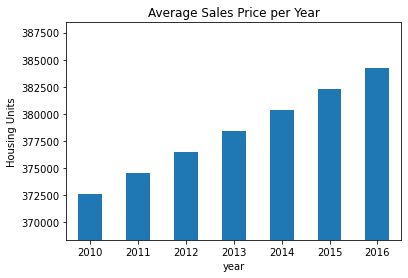

In [74]:
housing_units_column = pn.Column(
    '## Housing Units Sold per Year',
    housing_units_per_year()
)

averages_column = pn.Column(
    'Avg. Gross Rent, Sales Price, and Price by Neighborhood',
    average_gross_rent(),
    average_sales_price(),
    average_price_by_neighborhood()
)

top_ten_column = pn.Column(
    'Top Ten Most Expensive Neighborhoods',
    top_most_expensive_neighborhoods(),
)

parallel_column = pn.Column(
    '## Parallel Coordinates and Categories',
    parallel_coordinates(),
    parallel_categories(),
)

map_column = pn.Column(
    '## Average Values per Neighborhood Maps',
    neighborhood_map()
)

# Create tabs
sfo_dashboard = pn.Tabs(
    ('Housing Units Sold', housing_units_column),
    ('Averages', averages_column),
    ('Most Expensive', top_ten_column),
    ('Parallel Graphs', parallel_column),
    ('Map', map_column)
)

## Serve the Panel Dashboard

In [75]:
sfo_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(AxesSubplot)
    [1] Column
        [0] Markdown(str)
        [1] Str(Text)
        [2] Str(AxesSubplot)
        [3] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Curve)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [4] Column
        [0] Markdown(str)
        [1] Plotly(Figure)